Let's set up a Pavolovian conditioning experiment.

Agent A

Sensory input
* Vision: 10 bit vector. A specific sparse pattern indicates sight of food.
* Taste: 10 bit vector. A specific sparse pattern indicates taste of food.

Among uncorrelated sensory activity, the following pattern is hidden.

* Taste of food -- time delay t1 --> reward

Would this agent associate high reward prediction for Taste of food?

Later, the following pattern is presented.

* Sight of food --- time delay t0 --> Taste of food --- time delay t1 --> reward

Would the agent now associate high reward prediction for Sight of food? Will it stop associating Taste with reward (as seen from animal studies)?



In [0]:
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.style.use('classic')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


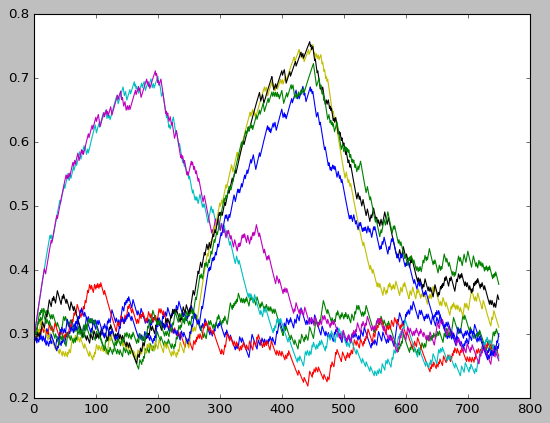

In [2]:
VISION_SIZE = 10
TASTE_SIZE = 5
REWARD_SIZE = 4

BASELINE_ACTIVATION = B = 0.3
HIGH_ACTIVATION = H = 0.8


class SpatialPattern:
  def __init__(self, values):
    self.poisson = Bernoulli(probs=values)

  def sample(self, shape):
    return self.poisson.sample(shape)

class TemporalPattern:
  def __init__(self, spatial_patterns, durations):
    self.spatial_patterns = spatial_patterns
    self.durations = durations
    
  def sample(self):
    all_samples = []
    for i in range(len(self.durations)):
      all_modalities_patterns = self.spatial_patterns[i]
      duration = self.durations[i]
      
      samples = [torch.tensor(all_modalities_patterns[j].sample([duration])) for j in range(len(all_modalities_patterns))]
      samples = torch.cat(samples, 1)
      all_samples.append(samples)
      
    return torch.cat(all_samples, 0)
    
class SensoryModality:      
  def __init__(self, size, baseline_activation):
    self.baseline_pattern = SpatialPattern(torch.ones(size) * baseline_activation)
    
  def baseline_sample(self, shape):
    return self.baseline_pattern.sample(shape)
  
  def create_spatial_pattern(self, values):
    return SpatialPattern(torch.tensor(values))

taste = SensoryModality(TASTE_SIZE, BASELINE_ACTIVATION)
reward = SensoryModality(REWARD_SIZE, BASELINE_ACTIVATION)

taste.create_spatial_pattern([B,B,B,H,H])


experiment1 = TemporalPattern(
  [
      [taste.create_spatial_pattern([B,B,B,H,H]), reward.baseline_pattern],
      [taste.baseline_pattern, reward.baseline_pattern],
      [taste.baseline_pattern, reward.create_spatial_pattern([H,H,H,H])],
      [taste.baseline_pattern, reward.baseline_pattern],
  ],
  [
      200,
      50,
      200,
      300,
  ]
)

data = experiment1.sample()
#print(data)

def trace(data, decay_rate=0.99):
  decay_rate = 0.99

  trace = torch.ones(data.shape[-1]) * B
  data_trace = [trace]

  for i in range(data.shape[0]):
    row = data[i]
    trace = trace * decay_rate + row * (1 - decay_rate)
    data_trace.append(trace)

  data_trace = torch.stack(data_trace)
  #print(data_trace)

  return data_trace

data_trace = trace(data)
plt.plot(data_trace.numpy())
plt.show()



In [7]:
class LocalEnsemble(nn.Module):
  def __init__(self, input_size, ensemble_size):
    super(LocalEnsemble, self).__init__()
    
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)

    self.input_size = input_size

    self.ensemble = nn.Linear(input_size, ensemble_size)
    self.initialize_sparse_weights(self.ensemble)
    
    self.lateral = nn.Linear(ensemble_size, ensemble_size)
    self.initialize_sparse_weights(self.lateral)
    
    self.previous_activation = torch.zeros(ensemble_size)
    
  def initialize_sparse_weights(self, layer):
    layer.weight.data = F.dropout(layer.weight.data, 0.8)

  def forward(self, x):
    afferent_activation = self.ensemble(x)
    lateral_activation = torch.tanh(self.lateral(self.previous_activation))
    
    activation = torch.sigmoid(afferent_activation + lateral_activation)
    
    self.previous_activation = activation
    return activation

model = LocalEnsemble(data_trace.shape[-1], 10)
print(model.ensemble.weight.data)
model.forward(data_trace) # burner


tensor([[-0.0000, -0.0000,  0.0000,  1.1000, -0.0000,  0.0000,  0.2018,  0.0000,
          0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
         -0.0000],
        [-0.0000,  1.3624,  0.7021, -1.3309,  0.0000, -0.0000, -1.1811,  0.0000,
         -1.4353],
        [ 0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000],
        [ 0.0000,  0.4324,  0.0000,  1.4315, -0.0000, -0.0000,  0.0000, -0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
         -0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          0.0000],
        [ 0.0000,  0.3919,  0.0000,  1.4466, -0.0000, -0.0000, -1.0800, -0.0000,
          0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  1.3346, -0.0000,
         -0.0000],
        [ 0.0000, -1.4612,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.8720,
          0.0000]])

tensor([[0.5093, 0.5769, 0.2613,  ..., 0.5505, 0.6262, 0.2718],
        [0.5083, 0.5769, 0.2664,  ..., 0.5509, 0.6253, 0.2703],
        [0.5101, 0.5769, 0.2647,  ..., 0.5549, 0.6244, 0.2688],
        ...,
        [0.5031, 0.5769, 0.2303,  ..., 0.5223, 0.6450, 0.2739],
        [0.5022, 0.5769, 0.2316,  ..., 0.5220, 0.6439, 0.2736],
        [0.5013, 0.5769, 0.2329,  ..., 0.5217, 0.6428, 0.2732]],
       grad_fn=<SigmoidBackward>)

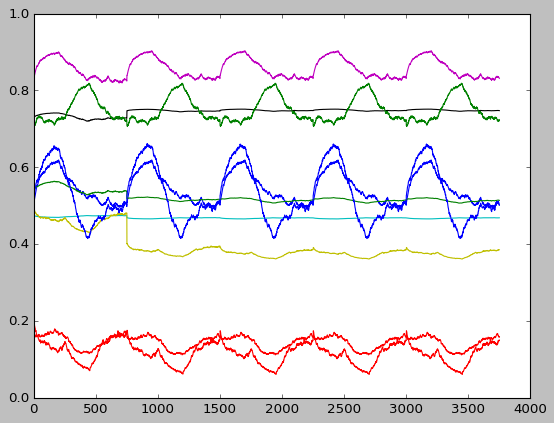

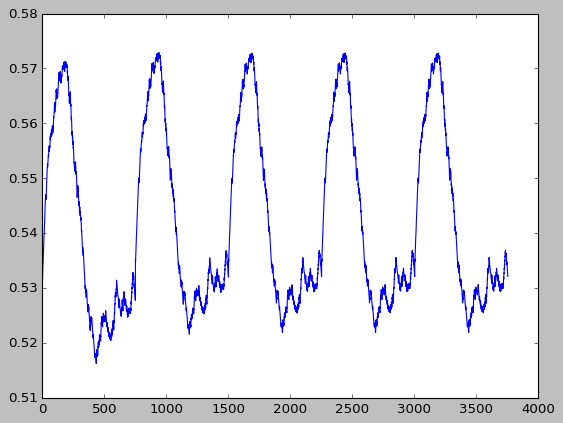

In [8]:
activations = [model.forward(data_trace) for _ in range(5)]
activations = torch.stack(activations)
# trace(activation.detach())
activations = activations.view(-1, activations.shape[-1])
#plt.plot(trace(activations.detach()).numpy())
plt.plot(activations.detach().numpy())
plt.show()

reward = activations[:, -REWARD_SIZE:].sum(dim=1).unsqueeze(dim=1) / REWARD_SIZE
#plt.plot(trace(reward.detach()).numpy())
plt.plot(reward.detach().numpy())
plt.show()